# TM10007 Assignment template

In [1]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn

# Preprocessing
from sklearn import model_selection

# Classifiers and kernels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from sklearn.model_selection import GridSearchCV, StratifiedKFold 
from sklearn import metrics
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [2]:
from worclipo.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
print(data)

The number of samples: 115
The number of columns: 494
                  label  PREDICT_original_sf_compactness_avg_2.5D  \
ID                                                                  
Lipo-001_0  liposarcoma                                  0.368434   
Lipo-002_0  liposarcoma                                  0.660571   
Lipo-003_0       lipoma                                  0.365191   
Lipo-004_0  liposarcoma                                  0.372210   
Lipo-005_0       lipoma                                  0.369120   
...                 ...                                       ...   
Lipo-111_0       lipoma                                  0.244813   
Lipo-112_0  liposarcoma                                  0.197353   
Lipo-113_0  liposarcoma                                  0.307562   
Lipo-114_0       lipoma                                  0.577333   
Lipo-115_0  liposarcoma                                  0.635282   

            PREDICT_original_sf_compactness_std_

In [16]:
"""Controleren op dubbele patienten en indien verwijderen"""
duplicates = data[data.duplicated(keep=False)]  
data = data.drop_duplicates(keep='first')
print(f"Aantal rijen na controle op duplicates: {len(data)}")

Aantal rijen na controle op duplicates: 115


In [17]:
"""Controleren op missende waarden"""
data_missing_values = data.replace(' ', np.nan)                   
missing_values = data[data.isnull().any(axis=1)]         

if not missing_values.empty:
    print(f"Missende waarden; {missing_values}")
else:
    print("Geen missende waarden")


Geen missende waarden


In [3]:
"""Splitting the data into a test and training dataset: outer cross-validation"""
#Outer cross-validation
#Split the dataset in train and test part
data_train, data_test = model_selection.train_test_split(data, test_size=0.20, random_state=17)
print(f'The number of samples train: {len(data_train.index)}')
print(f'The number of columns train: {len(data_train.columns)}')
print(f'The number of samples test: {len(data_test.index)}')
print(f'The number of columns test: {len(data_test.columns)}')

The number of samples train: 92
The number of columns train: 494
The number of samples test: 23
The number of columns test: 494


In [4]:
# Outliers detecteren en vervangen
from outliers import outlier_detection
data_train, total_outliers = outlier_detection(data_train)
print("\nTotaal aantal gecapte outliers train data:", total_outliers)

data_test, total_outliers = outlier_detection(data_test)
print("\nTotaal aantal gecapte outliers test data:", total_outliers)


Totaal aantal gecapte outliers train data: 633

Totaal aantal gecapte outliers test data: 164


In [6]:
from prepro_data import processing_data_scaling
#This data is scaled and a variance and correlation threshold are applied
data_scaled, df_label, df_processed= processing_data_scaling(data_train)
print(data_scaled)

                  label         0         1         2         3         4  \
ID                                                                          
Lipo-005_0       lipoma  1.921320  2.300469 -0.704704 -0.290661 -0.407842   
Lipo-074_0  liposarcoma -0.685279 -0.820552 -0.535280 -0.582133 -0.110386   
Lipo-067_0       lipoma  0.279670  0.387813 -0.633264 -0.062485 -0.195036   
Lipo-029_0       lipoma -0.316884  0.661753 -0.548148 -0.493576 -0.515409   
Lipo-107_0       lipoma -0.117278 -0.070134 -0.659508 -0.760142 -0.807204   
...                 ...       ...       ...       ...       ...       ...   
Lipo-023_0       lipoma  2.737678  2.126752 -0.591508 -0.147823 -0.299182   
Lipo-007_0       lipoma -0.054516  0.023320  1.374881 -0.490456 -0.245513   
Lipo-016_0  liposarcoma  0.219615 -0.922562 -0.366795  1.488417  3.113260   
Lipo-114_0       lipoma -0.380788 -0.413973 -0.682292 -0.578136 -0.744173   
Lipo-112_0  liposarcoma -0.040726 -0.079727 -0.758099 -0.612074 -0.609167   

In [6]:
from prepro_data import processing_data_pca
#This data is scaled, a variance and correlation threshold are applied, 
# and PCA brought back the number of features to 36
data_pca, df_label, df_processed= processing_data_pca(data_train)
print(data_pca)
print(df_label)
print(df_processed)

                  label         0         1         2         3         4  \
ID                                                                          
Lipo-005_0       lipoma -6.741350 -4.763484 -2.624851  2.563355  0.096286   
Lipo-074_0  liposarcoma -1.055906  0.972463 -3.979988  9.157892 -2.725961   
Lipo-067_0       lipoma -5.328686  0.512865 -2.470933 -1.047994  1.306582   
Lipo-029_0       lipoma -1.580797  7.689689 -1.200930 -0.653949  1.306447   
Lipo-107_0       lipoma -2.396952 -0.161927 -3.264465 -3.024346 -1.427121   
...                 ...       ...       ...       ...       ...       ...   
Lipo-023_0       lipoma -8.190188 -7.277740 -0.293829 -0.864164 -2.876892   
Lipo-007_0       lipoma -0.708823 -1.201887 -3.510810 -2.371504  0.474262   
Lipo-016_0  liposarcoma -8.387105  1.314307  1.147218 -3.719983 -1.674119   
Lipo-114_0       lipoma  2.929006 -1.232101 -1.553439 -1.670373 -2.204223   
Lipo-112_0  liposarcoma -2.404459 -0.923681  3.463144 -0.488366  0.742777   

                   2         4        19        20        40        47  \
ID                                                                       
Lipo-005_0 -0.704704 -0.407842  1.319153  1.830829  0.267129 -0.131277   
Lipo-074_0 -0.535280 -0.110386 -0.722998  0.591748 -0.899496  0.390132   
Lipo-067_0 -0.633264 -0.195036 -0.139526 -0.306735  0.073545 -0.907477   
Lipo-029_0 -0.548148 -0.515409  1.027418 -0.427692 -0.920224 -0.685384   
Lipo-107_0 -0.659508 -0.807204 -0.139526 -0.448478  0.028983 -0.622104   
...              ...       ...       ...       ...       ...       ...   
Lipo-023_0 -0.591508 -0.299182  0.152210  0.624858  0.501752 -0.397111   
Lipo-007_0  1.374881 -0.245513  1.027418 -0.282605  0.564445 -0.245241   
Lipo-016_0 -0.366795  3.113260  0.152210 -0.366622  0.508871 -0.759792   
Lipo-114_0 -0.682292 -0.744173  0.443946 -0.533506 -0.445744  0.092812   
Lipo-112_0 -0.758099 -0.609167 -1.014733 -0.366444 -0.308910 -0.220173   

                  58        64       

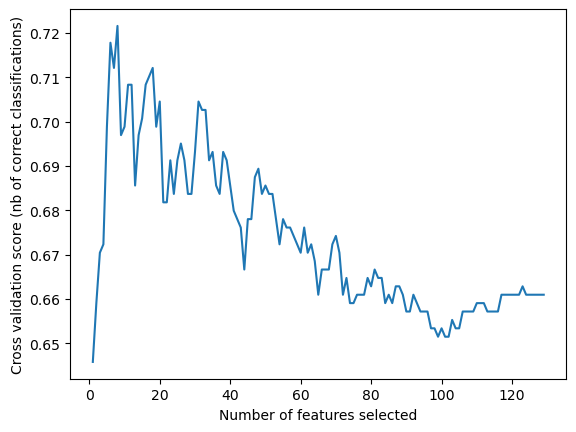

In [7]:
from prepro_data import processing_data_rfecv
#This data is scaled, a variance and correlation threshold are applied,
# and RFECV brought back the number of features to 61 (takes a bit longer to run)
data_rf, df_label, df_processed= processing_data_rfecv(data_train)
print(data_rf)

In [ ]:
"""Support Vector Machine"""
# Split data into features and labels
X = data_pca.drop(data_rf.columns[[0, 1]], axis=1)  # Features
Y = df_label['label']  # Labels

# Set up the parameter grid for GridSearchCV
param_grid = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10]},
    {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.1, 1]},
    {'kernel': ['poly'], 'C': [0.1, 1, 10], 'degree': [3, 4, 5], 'gamma': ['scale', 'auto', 0.1, 1], 'coef0': [0.0, 0.1, 0.5]},
]

# Set up the SVM classifier
svm_classifier = SVC(random_state=42, probability=True)  # Enable probability for AUC calculation

# Set up inner cross-validation for hyperparameter tuning
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(
    estimator=svm_classifier, 
    param_grid=param_grid, 
    cv=inner_cv, 
    n_jobs=-1, 
    verbose=1, 
    scoring=['roc_auc', 'f1'],  # Optimize for both AUC and F1-score
    refit='roc_auc'  # Select the best model based on AUC
)

# Perform the grid search on the training data to find the best hyperparameters
grid_search.fit(X, Y)

# Get the best model (with the best hyperparameters)
best_model = grid_search.best_estimator_

# Make predictions to evaluate performance
y_pred = best_model.predict(X)
y_pred_proba = best_model.predict_proba(X)[:, 1]  # Probability estimates for AUC

# Convert categorical labels to numerical labels (0 or 1)
le = LabelEncoder()
Y = le.fit_transform(Y)  # 'lipoma' -> 0, 'liposarcoma' -> 1

# Ensure predictions are also numerical
y_pred = best_model.predict(X)
y_pred = le.transform(y_pred)  # Convert categorical predictions ('lipoma', 'liposarcoma') to 0 and 1

# Calculate evaluation metrics
auc_score = roc_auc_score(Y, y_pred_proba)
f1 = f1_score(Y, y_pred)

# Print results
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Training AUC: {auc_score:.4f}")
print(f"Training F1-score: {f1:.4f}")

Fitting 5 folds for each of 123 candidates, totalling 615 fits
Best hyperparameters: {'C': 0.1, 'coef0': 0.5, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
Training AUC: 0.9560
Training F1-score: 0.7500


c:\Users\Kools\miniconda3\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [11]:
"""Random Forest"""
from prepro_data import split_data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_validate
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from scipy.stats import randint

# Split data into features and labels
data_selection, data_id, df_label = split_data(data_train)

rf_classifier = RandomForestClassifier(random_state=42)

# Define the outer cross-validation (for evaluating model performance)
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define the inner cross-validation (for hyperparameter tuning)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X = data_selection  # Features
Y = df_label      # Labels

# Define the parameter grid for GridSearchCV
param_dist = {
    'n_estimators': randint(10, 200),        # Randomly sample number of trees between 10 and 200
    'max_depth': [None, 10, 20, 30, 40],      # Randomly sample max_depth options
    'min_samples_split': randint(2, 20),     # Randomly sample minimum samples for split
    'min_samples_leaf': randint(1, 20),      # Randomly sample minimum samples for leaf
    'bootstrap': [True, False]               # Bootstrap sampling options
}

# Define scoring metrics for cross-validation
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score, pos_label='liposarcoma'),  # Specify 'liposarcoma' as the positive class for F1 score
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr', average='macro')  # Multi-class ROC-AUC
}

random_search = RandomizedSearchCV(
    rf_classifier, param_distributions=param_dist, n_iter=20, cv=inner_cv, random_state=42, n_jobs=-1, verbose=2)

random_search.fit(X, Y)
print("Best Hyperparameters from RandomizedSearchCV:", random_search.best_params_)

# Perform cross-validation and get multiple metrics
cv_results = cross_validate(
    random_search, X, Y, scoring=scoring, cv=outer_cv, return_train_score=False)

# Print the evaluation metrics
print(f'Nested Cross-Validation Accuracy: {cv_results["test_accuracy"].mean()}')
print(f'Average F1 Score: {cv_results["test_f1"].mean()}')
print(f'Average ROC-AUC: {cv_results["test_roc_auc"].mean()}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Kools\miniconda3\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Hyperparameters from RandomizedSearchCV: {'bootstrap': True, 'max_depth': 40, 'min_samples_leaf': 9, 'min_samples_split': 8, 'n_estimators': 27}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Kools\miniconda3\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Kools\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Kools\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\Kools\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Kools\miniconda3\Lib\site-packages\sklearn\utils\_param_validati

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Kools\miniconda3\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Kools\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Kools\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\Kools\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Kools\miniconda3\Lib\site-packages\sklearn\utils\_param_validati

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Kools\miniconda3\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Nested Cross-Validation Accuracy: 0.6845878136200717
Average F1 Score: 0.6398724732058065
Average ROC-AUC: nan


c:\Users\Kools\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Kools\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\Kools\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Kools\miniconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Kools\miniconda3\Lib\inspect.py", line 3277, in bind
    return self._bind(args, kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:

In [12]:
"""KNNeighbour classifier"""
# Split data into features and labels
X = data_rf.drop(data_rf.columns[[0, 1]], axis=1)  # Features (excluding first two columns)
Y = df_label['label']  # Labels

# Set up the parameter grid for GridSearchCV (for KNN, we mainly tune 'n_neighbors', 'weights', and 'metric')
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15],  # Trying different values for k (number of neighbors)
    'weights': ['uniform', 'distance'],  # Weighting of neighbors
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metrics to use
}

# Set up the KNN classifier
knn_classifier = KNeighborsClassifier()  # KNN classifier

# Set up inner cross-validation for hyperparameter tuning
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(
    estimator=knn_classifier, 
    param_grid=param_grid, 
    cv=inner_cv, 
    n_jobs=-1, 
    verbose=1, 
    scoring=['roc_auc', 'f1'],  # Optimize for both AUC and F1-score
    refit='roc_auc'  # Select the best model based on AUC
)

# Perform the grid search on the training data to find the best hyperparameters
grid_search.fit(X, Y)

# Get the best model (with the best hyperparameters)
best_model = grid_search.best_estimator_

# Make predictions to evaluate performance
y_pred = best_model.predict(X)
y_pred_proba = best_model.predict_proba(X)[:, 1]  # Probability estimates for AUC

# Convert categorical labels to numerical labels (0 or 1)
le = LabelEncoder()
Y = le.fit_transform(Y)  # 'lipoma' -> 0, 'liposarcoma' -> 1

# Ensure predictions are also numerical
y_pred = best_model.predict(X)
y_pred = le.transform(y_pred)  # Convert categorical predictions ('lipoma', 'liposarcoma') to 0 and 1

# Calculate evaluation metrics
auc_score = roc_auc_score(Y, y_pred_proba)
f1 = f1_score(Y, y_pred)

# Print results
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Training AUC: {auc_score:.4f}")
print(f"Training F1-score: {f1:.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\Kools\miniconda3\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best hyperparameters: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Training AUC: 1.0000
Training F1-score: 1.0000
